In [1]:
import math
import numpy as np
import pypulseq as pp

In [ ]:
np.version.version # should be version 1.23 or below to overcome np.float error

Adjust add_gradients and make_extended_trapezoid_area functions accordingly. 

Timing check passed successfully
Sequence ready
TR=8.300 ms  TE=4.150 ms
253061.22448979592


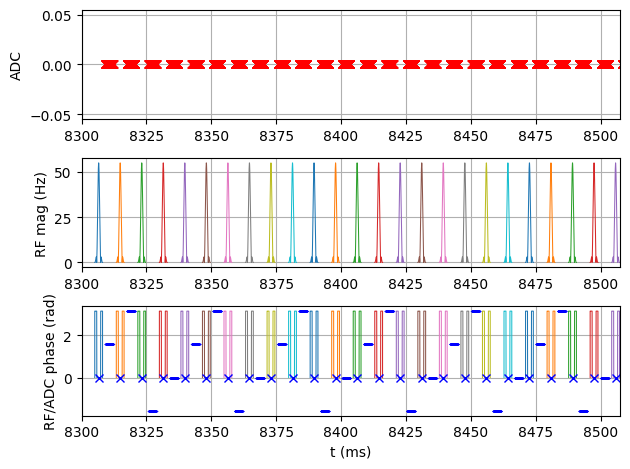

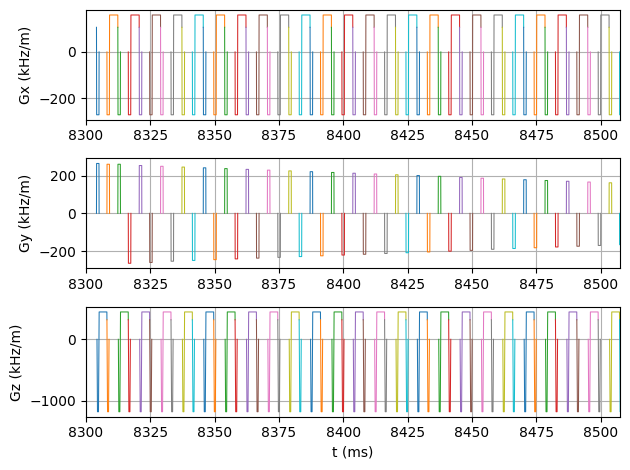

/home/yaskhanloo/.local/lib/python3.10/site-packages/numpy/polynomial/polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
/home/yaskhanloo/.local/lib/python3.10/site-packages/pypulseq/Sequence/sequence.py:404: RuntimeWarning: invalid value encountered in divide
  slice_pos[j] = np.divide(


Number of blocks: 13537
Number of events:
RF:   6769
Gx:  13536
Gy:  13536
Gz:  13537
ADC:    768
Delay:      0
Sequence duration: 56.178460 s
TE: 74.574878 s
TR: 0.008300 s
Flip angle: 15.00 deg
Unique k-space positions (aka cols, rows, etc.): 33 270 29 
Dimensions: 3
Spatial resolution: 1.94 mm
Spatial resolution: 0.99 mm
Spatial resolution: 0.71 mm
Repetitions/slices/contrasts: 4.0; range: [(1.0, 79534.0)]
Non-cartesian/irregular encoding trajectory detected (eg: EPI, spiral, radial, etc.)
Event timing check passed successfully
Max gradient: 272000 263918 1176245 Hz/m == 6.39 6.20 27.63 mT/m
Max slew rate: 5440000001 6336633666 6349206350 Hz/m/s == 127.77 148.83 149.13 T/m/s
Max absolute gradient: 1235795 Hz/m == 29.03 mT/m
Max absolute slew rate: 1.22978e+23 Hz/m/s == 2888441700129893.00 T/m/s


In [2]:
# PCbSSFP, 1000 prep pulse, tested on NIST 20231027, ellipses dont close
def main(plot: bool, write_seq: bool, seq_filename: str = "PCbSSFP_36PC_20240219.seq"):
    # ======
    # SETUP
    # ======
    seq = pp.Sequence()  # Create a new sequence object

    fov = 250e-3  # Define FOV and resolution
    Nx = 128
    Ny = Nx
    alpha = 30  # Flip angle
    slice_thickness = 3e-3  # Slice thickness
    n_slices = 1

    # there is no user control for TR/TE,
    # specify the ADC time and RF parameters
    # calculate to find the fastest posible timing.
    # TR = 10e-3  # Repetition time
    # TE = TR / 2

    rf_spoiling_inc = 117  # RF spoiling increment
    ro_duration = 3.2e-3  # ADC duration controls TR/TE

    # Set system limits
    system = pp.Opts(
        max_grad=28,
        grad_unit="mT/m",
        max_slew=150,
        slew_unit="T/m/s",
        rf_ringdown_time=20e-6,
        rf_dead_time=100e-6,
        adc_dead_time=10e-6,
    )
    # ======
    # CREATE EVENTS
    # ======
    # Create alpha-degree slice selection pulse and gradient
    rf, gz, gz_reph = pp.make_sinc_pulse(
        flip_angle=alpha * np.pi / 180,
        duration=3e-3,
        slice_thickness=slice_thickness,
        apodization=0.5,
        time_bw_product=4, # 1.5 Trufi
        system=system,
        return_gz=True,
    )

    # Define other gradients and ADC events
    delta_k = 1 / fov
    gx = pp.make_trapezoid(
        channel="x", flat_area=Nx * delta_k, flat_time=ro_duration, system=system
    )
    adc = pp.make_adc(
        num_samples=Nx, duration=gx.flat_time, delay=gx.rise_time, system=system
    )
    gx_pre = pp.make_trapezoid(
        channel="x", area=-gx.area / 2, duration=1e-3, system=system
    )
    phase_areas = -(np.arange(Ny) - Ny / 2) * delta_k

    # adapt from writeTrufi.m
    # reshuffle gradients -> half-way optimal timing
    # two part gz
    # 1: slice refocusing from the previous TR followed by slice selection
    #      including the plato an a small bit of the ramp-down
    # 2: the remainder of the ramp-down and the slice refocusing for the next TR
    gz_parts = pp.split_gradient_at(
        grad=gz, time_point=pp.calc_duration(rf), system=system
    )
    gz_parts[0].delay = pp.calc_duration(gz_reph)
    gz_1 = pp.add_gradients((gz_reph, gz_parts[0]), system=system)
    rf, _ = pp.align(right=[rf, gz_1])
    gz_parts[1].delay = 0
    gz_reph.delay = pp.calc_duration(gz_parts[1])
    gz_2 = pp.add_gradients((gz_parts[1], gz_reph), system=system)

    # new gr will consist of two parts:
    # 1: prephaser followed by a part of the read gradient including the
    #       beginning of the ramp-down
    # 2: the remainer of the ramp-down and the second "prephaser"
    gx_parts = pp.split_gradient_at(gx, np.ceil(pp.calc_duration(adc)/system.grad_raster_time)*system.grad_raster_time)
    gx_parts[0].delay = pp.calc_duration(gx_pre)
    gx_1 = pp.add_gradients((gx_pre, gx_parts[0]), system=system)
    # cannot use pp.align here because the adc duration may be not aligneed to the grad raster
    adc.delay = adc.delay + pp.calc_duration(gx_pre)
    gx_parts[1].delay = 0
    gx_pre.delay = pp.calc_duration(gx_parts[1])
    gx_2 = pp.add_gradients((gx_parts[1], gx_pre), system=system)

    # Gradient spoiling
    #gx_spoil = pp.make_trapezoid(channel="x", area=2 * Nx * delta_k, system=system)
    #gz_spoil = pp.make_trapezoid(channel="z", area=4 / slice_thickness, system=system)

    # Calculate timing
    gx_pre.delay = 0
    pe_dur = pp.calc_duration(gx_2)
    # rf.ringdown_time is needed to center the ADC and the gradient echo in the center of RF-RF period
    gz_1.delay = max(pp.calc_duration(gx_2)-rf.delay+rf.ringdown_time, 0)

    rf.delay = rf.delay + gz_1.delay

    TR = pp.calc_duration(gz_1) + pp.calc_duration(gx_1)
    TE = TR/2

    rf05 = rf
    rf05.signal = 0.5 * rf.signal

    # label following blocks as preparing to exclude them if the sequence is repeated
    seq.add_block(rf05, gz_1, pp.make_label(label="REV", type="SET", value=1)) # check

    prep_delay = pp.make_delay(np.round((TR/2 - pp.calc_duration(gz_1))/system.grad_raster_time)*system.grad_raster_time)

    gx_2.area = sum(gx_2.waveform)*system.grad_raster_time # should be added to the main function

    gx_1_1 = pp.make_extended_trapezoid_area(
        channel = 'x',  grad_start = 0, grad_end = gx_2.first, area = -gx_2.area, system = system
    )
    gy_pre2 = pp.make_trapezoid(
        channel = 'y', area = phase_areas[-1], duration = pe_dur, system = system
    )
    #seq.add_block(pp.align(left=[prep_delay, gz_2, gy_pre2], right=[gx_1_1]))
    #seq.add_block(pp.make_label(label="REV", type="SET", value=0))

    # ======
    # CONSTRUCT SEQUENCE
    # ======
    # Phase Cycles
    pcs = np.arange(0, 360, 60)
    pcs = -pcs / 180 *(np.pi)
    rf_phase = -np.pi

    # Loops
    rf.phase_offset = 0
    adc.phase_offset = 0 #pi/2 difference with rf.phase_offset
    for pc in pcs:
     for pre in range(1000):
            rf.phase_offset = np.mod(rf.phase_offset + pc, 2*np.pi)
            adc.phase_offset = np.mod(adc.phase_offset + pc + np.pi/2, 2*np.pi)
            gy_pre1 = pp.make_trapezoid(
                channel="y",
                area=0,
                duration=pe_dur,
                system=system,
            )
            seq.add_block(rf, gz_1, gy_pre1, gx_2)
            seq.add_block(gx_1, gy_pre1, gz_2)

     for s in range(n_slices):
        rf.freq_offset = gz.amplitude * slice_thickness * (s - (n_slices - 1) / 2)
        #Loop over phase encodes
        for i in range(Ny):
              # add another loop for diff TEs
                gy_pre1 = pp.scale_grad(grad=gy_pre2, scale=-1)
                gy_pre2 = pp.make_trapezoid(
                    channel="y",
                    area= phase_areas[i],
                    duration=pe_dur,
                    system=system,
                )
                rf.phase_offset = np.mod(rf.phase_offset + pc, 2*np.pi)
                adc.phase_offset = np.mod(adc.phase_offset + pc + np.pi/2, 2*np.pi)
                seq.add_block(rf, gz_1, gy_pre2, gx_2)
                seq.add_block(gx_1, gy_pre1, gz_2, adc)

    #seq.add_block(gx_2, pp.make_label(label="REV", type="SET", value=2))

    ok, error_report = seq.check_timing()
    if ok:
        print("Timing check passed successfully")
    else:
        print("Timing check failed. Error listing follows:")
        [print(e) for e in error_report]


    TR = (pp.calc_duration(seq.get_block(5)) + pp.calc_duration(seq.get_block(6)))
    #assert TR == desired_TR  # Replace `desired_TR` with the expected TR value

    print('Sequence ready')
    print(f'TR={TR * 1e3:.3f} ms  TE={TE * 1e3:.3f} ms')
    print(gy_pre1.amplitude)

    # ======
    # VISUALIZATION
    # ======
    if plot:
        seq.plot(label="lin", time_range=np.array([1000, 1025]) * TR, time_disp="ms")
      #  seq.plot(label="lin", time_disp="ms")

    rep = seq.test_report()
    print(rep)

    # =========
    # WRITE .SEQ
    # =========
    if write_seq:
    # Prepare the sequence output for the scanner
        seq.set_definition(key="FOV", value=[fov, fov, slice_thickness * n_slices])
        seq.set_definition(key="Name", value="bSSFP")
        seq.write(seq_filename)

if __name__ == "__main__":
    main(plot=True, write_seq=True)

In [ ]:
# PCbSSFP, 1000 prep pulse, make it 3D with slab selection or match the parameters with the one from IDEA, change PC to 36 instead of 6
def main(plot: bool, write_seq: bool, seq_filename: str = "PCbSSFP_1slc_36PC_20231102.seq"):
    # ======
    # SETUP
    # ======
    seq = pp.Sequence()  # Create a new sequence object

    fov = 176e-3  # Define FOV and resolution
    Nx = 176
    Ny = Nx
    alpha = 15  # Flip angle
    slice_thickness = 3e-3  # Slice thickness
    n_slices = 1

    # there is no user control for TR/TE,
    # specify the ADC time and RF parameters
    # calculate to find the fastest posible timing.
    # TR = 10e-3  # Repetition time
    # TE = TR / 2

    rf_spoiling_inc = 117  # RF spoiling increment
    ro_duration = 3.2e-3  # ADC duration controls TR/TE

    # Set system limits
    system = pp.Opts(
        max_grad=28,
        grad_unit="mT/m",
        max_slew=150,
        slew_unit="T/m/s",
        rf_ringdown_time=20e-6,
        rf_dead_time=100e-6,
        adc_dead_time=10e-6,
    )
    # ======
    # CREATE EVENTS
    # ======
    # Create alpha-degree slice selection pulse and gradient
    rf, gz, gz_reph = pp.make_sinc_pulse(
        flip_angle=alpha * np.pi / 180,
        duration=3e-3,
        slice_thickness=slice_thickness,
        apodization=0.5,
        time_bw_product=4, # 1.5 Trufi
        system=system,
        return_gz=True,
    )

    # Define other gradients and ADC events
    delta_k = 1 / fov
    gx = pp.make_trapezoid(
        channel="x", flat_area=Nx * delta_k, flat_time=ro_duration, system=system
    )
    adc = pp.make_adc(
        num_samples=Nx, duration=gx.flat_time, delay=gx.rise_time, system=system
    )
    gx_pre = pp.make_trapezoid(
        channel="x", area=-gx.area / 2, duration=1e-3, system=system
    )
    phase_areas = -(np.arange(Ny) - Ny / 2) * delta_k

    # adapt from writeTrufi.m
    # reshuffle gradients -> half-way optimal timing
    # two part gz
    # 1: slice refocusing from the previous TR followed by slice selection
    #      including the plato an a small bit of the ramp-down
    # 2: the remainder of the ramp-down and the slice refocusing for the next TR
    gz_parts = pp.split_gradient_at(
        grad=gz, time_point=pp.calc_duration(rf), system=system
    )
    gz_parts[0].delay = pp.calc_duration(gz_reph)
    gz_1 = pp.add_gradients((gz_reph, gz_parts[0]), system=system)
    rf, _ = pp.align(right=[rf, gz_1])
    gz_parts[1].delay = 0
    gz_reph.delay = pp.calc_duration(gz_parts[1])
    gz_2 = pp.add_gradients((gz_parts[1], gz_reph), system=system)

    # new gr will consist of two parts:
    # 1: prephaser followed by a part of the read gradient including the
    #       beginning of the ramp-down
    # 2: the remainer of the ramp-down and the second "prephaser"
    gx_parts = pp.split_gradient_at(gx, np.ceil(pp.calc_duration(adc)/system.grad_raster_time)*system.grad_raster_time)
    gx_parts[0].delay = pp.calc_duration(gx_pre)
    gx_1 = pp.add_gradients((gx_pre, gx_parts[0]), system=system)
    # cannot use pp.align here because the adc duration may be not aligneed to the grad raster
    adc.delay = adc.delay + pp.calc_duration(gx_pre)
    gx_parts[1].delay = 0
    gx_pre.delay = pp.calc_duration(gx_parts[1])
    gx_2 = pp.add_gradients((gx_parts[1], gx_pre), system=system)

    # Gradient spoiling
    #gx_spoil = pp.make_trapezoid(channel="x", area=2 * Nx * delta_k, system=system)
    #gz_spoil = pp.make_trapezoid(channel="z", area=4 / slice_thickness, system=system)

    # Calculate timing
    gx_pre.delay = 0
    pe_dur = pp.calc_duration(gx_2)
    # rf.ringdown_time is needed to center the ADC and the gradient echo in the center of RF-RF period
    gz_1.delay = max(pp.calc_duration(gx_2)-rf.delay+rf.ringdown_time, 0)

    rf.delay = rf.delay + gz_1.delay

    TR = pp.calc_duration(gz_1) + pp.calc_duration(gx_1)
    TE = TR/2

    rf05 = rf
    rf05.signal = 0.5 * rf.signal

    # label following blocks as preparing to exclude them if the sequence is repeated
    seq.add_block(rf05, gz_1, pp.make_label(label="REV", type="SET", value=1)) # check

    prep_delay = pp.make_delay(np.round((TR/2 - pp.calc_duration(gz_1))/system.grad_raster_time)*system.grad_raster_time)

    gx_2.area = sum(gx_2.waveform)*system.grad_raster_time # should be added to the main function

    gx_1_1 = pp.make_extended_trapezoid_area(
        channel = 'x',  grad_start = 0, grad_end = gx_2.first, area = -gx_2.area, system = system
    )
    gy_pre2 = pp.make_trapezoid(
        channel = 'y', area = phase_areas[-1], duration = pe_dur, system = system
    )
    #seq.add_block(pp.align(left=[prep_delay, gz_2, gy_pre2], right=[gx_1_1]))
    #seq.add_block(pp.make_label(label="REV", type="SET", value=0))

    # ======
    # CONSTRUCT SEQUENCE
    # ======
    # Phase Cycles
    pcs = np.arange(0, 360, 10)
    pcs = -pcs / 180 *(np.pi)
    rf_phase = -np.pi

    # Loops
    for pc in pcs:
     rf_phase = pc
     rf.phase_offset = rf_phase
     adc.phase_offset = rf_phase
     for pre in range(1000):
            rf.phase_offset = np.mod(rf.phase_offset + pc, 2*np.pi)
            adc.phase_offset = np.mod(adc.phase_offset + pc, 2*np.pi)
            gy_pre1 = pp.make_trapezoid(
                channel="y",
                area=0,
                duration=pe_dur,
                system=system,
            )
            seq.add_block(rf, gz_1, gy_pre1, gx_2)
            seq.add_block(gx_1, gy_pre1, gz_2)

     for s in range(n_slices):
        rf.freq_offset = gz.amplitude * slice_thickness * (s - (n_slices - 1) / 2)
        #Loop over phase encodes
        for i in range(Ny):
              # add another loop for diff TEs
                gy_pre1 = pp.scale_grad(grad=gy_pre2, scale=-1)
                gy_pre2 = pp.make_trapezoid(
                    channel="y",
                    area= phase_areas[i],
                    duration=pe_dur,
                    system=system,
                )
                rf.phase_offset = np.mod(rf.phase_offset + pc, 2*np.pi)
                adc.phase_offset = np.mod(adc.phase_offset + pc, 2*np.pi)
                seq.add_block(rf, gz_1, gy_pre2, gx_2)
                seq.add_block(gx_1, gy_pre1, gz_2, adc)

    #seq.add_block(gx_2, pp.make_label(label="REV", type="SET", value=2))

    ok, error_report = seq.check_timing()
    if ok:
        print("Timing check passed successfully")
    else:
        print("Timing check failed. Error listing follows:")
        [print(e) for e in error_report]


    TR = (pp.calc_duration(seq.get_block(5)) + pp.calc_duration(seq.get_block(6)))
    #assert TR == desired_TR  # Replace `desired_TR` with the expected TR value

    print('Sequence ready')
    print(f'TR={TR * 1e3:.3f} ms  TE={TE * 1e3:.3f} ms')

    # ======
    # VISUALIZATION
    # ======
    if plot:
        #seq.plot(label="lin", time_range=np.array([20, 25]) * TR, time_disp="ms")
        seq.plot(label="lin", time_disp="ms")

   # seq.calculate_kspacePP()

    # rep = seq.test_report()
    # print(rep)
    # =========
    # WRITE .SEQ
    # =========
    if write_seq:
        # Prepare the sequence output for the scanner
        seq.set_definition(key="FOV", value=[fov, fov, slice_thickness * n_slices])
        seq.set_definition(key="Name", value="bSSFP")

        seq.write(seq_filename)

if __name__ == "__main__":
    main(plot=False, write_seq=True)

In [ ]:
# PCbSSFP, 1000 prep pulse
def main(plot: bool, write_seq: bool, seq_filename: str = "PCbSSFP_6PC_20231017_DWX.seq"):
    # ======
    # SETUP
    # ======
    seq = pp.Sequence()  # Create a new sequence object

    fov = 250e-3  # Define FOV and resolution
    Nx = 128
    Ny = Nx
    alpha = 30  # Flip angle
    slice_thickness = 3e-3  # Slice thickness
    n_slices = 1

    # there is no user control for TR/TE,
    # specify the ADC time and RF parameters
    # calculate to find the fastest posible timing.
    # TR = 10e-3  # Repetition time
    # TE = TR / 2

    rf_spoiling_inc = 117  # RF spoiling increment
    ro_duration = 3.2e-3  # ADC duration controls TR/TE

    # Set system limits
    system = pp.Opts(
        max_grad=28,
        grad_unit="mT/m",
        max_slew=150,
        slew_unit="T/m/s",
        rf_ringdown_time=20e-6,
        rf_dead_time=100e-6,
        adc_dead_time=10e-6,
    )
    # ======
    # CREATE EVENTS
    # ======
    # Create alpha-degree slice selection pulse and gradient
    rf, gz, gz_reph = pp.make_sinc_pulse(
        flip_angle=alpha * np.pi / 180,
        duration=3e-3,
        slice_thickness=slice_thickness,
        apodization=0.5,
        time_bw_product=4, # 1.5 Trufi
        system=system,
        return_gz=True,
    )

    # Define other gradients and ADC events
    delta_k = 1 / fov
    gx = pp.make_trapezoid(
        channel="x", flat_area=Nx * delta_k, flat_time=ro_duration, system=system
    )
    adc = pp.make_adc(
        num_samples=Nx, duration=gx.flat_time, delay=gx.rise_time, system=system
    )
    gx_pre = pp.make_trapezoid(
        channel="x", area=-gx.area / 2, duration=1e-3, system=system
    )
    phase_areas_1 = -(np.arange(Ny)) * delta_k
    phase_areas_2 = (np.arange(1,1,Ny)) * delta_k
    phase_areas = np.concatenate((phase_areas_1, phase_areas_2), axis=None)
    # adapt from writeTrufi.m
    # reshuffle gradients -> half-way optimal timing
    # two part gz
    # 1: slice refocusing from the previous TR followed by slice selection
    #      including the plato an a small bit of the ramp-down
    # 2: the remainder of the ramp-down and the slice refocusing for the next TR
    gz_parts = pp.split_gradient_at(
        grad=gz, time_point=pp.calc_duration(rf), system=system
    )
    gz_parts[0].delay = pp.calc_duration(gz_reph)
    gz_1 = pp.add_gradients((gz_reph, gz_parts[0]), system=system)
    rf, _ = pp.align(right=[rf, gz_1])
    gz_parts[1].delay = 0
    gz_reph.delay = pp.calc_duration(gz_parts[1])
    gz_2 = pp.add_gradients((gz_parts[1], gz_reph), system=system)

    # new gr will consist of two parts:
    # 1: prephaser followed by a part of the read gradient including the
    #       beginning of the ramp-down
    # 2: the remainer of the ramp-down and the second "prephaser"
    gx_parts = pp.split_gradient_at(gx, np.ceil(pp.calc_duration(adc)/system.grad_raster_time)*system.grad_raster_time)
    gx_parts[0].delay = pp.calc_duration(gx_pre)
    gx_1 = pp.add_gradients((gx_pre, gx_parts[0]), system=system)
    # cannot use pp.align here because the adc duration may be not aligneed to the grad raster
    adc.delay = adc.delay + pp.calc_duration(gx_pre)
    gx_parts[1].delay = 0
    gx_pre.delay = pp.calc_duration(gx_parts[1])
    gx_2 = pp.add_gradients((gx_parts[1], gx_pre), system=system)

    # Gradient spoiling
    #gx_spoil = pp.make_trapezoid(channel="x", area=2 * Nx * delta_k, system=system)
    #gz_spoil = pp.make_trapezoid(channel="z", area=4 / slice_thickness, system=system)

    # Calculate timing
    gx_pre.delay = 0
    pe_dur = pp.calc_duration(gx_2)
    # rf.ringdown_time is needed to center the ADC and the gradient echo in the center of RF-RF period
    gz_1.delay = max(pp.calc_duration(gx_2)-rf.delay+rf.ringdown_time, 0)

    rf.delay = rf.delay + gz_1.delay

    TR = pp.calc_duration(gz_1) + pp.calc_duration(gx_1)
    TE = TR/2

    rf05 = rf
    rf05.signal = 0.5 * rf.signal

    # label following blocks as preparing to exclude them if the sequence is repeated
    seq.add_block(rf05, gz_1, pp.make_label(label="REV", type="SET", value=1)) # check

    prep_delay = pp.make_delay(np.round((TR/2 - pp.calc_duration(gz_1))/system.grad_raster_time)*system.grad_raster_time)

    gx_2.area = sum(gx_2.waveform)*system.grad_raster_time # should be added to the main function

    gx_1_1 = pp.make_extended_trapezoid_area(
        channel = 'x',  grad_start = 0, grad_end = gx_2.first, area = -gx_2.area, system = system
    )
    gy_pre2 = pp.make_trapezoid(
        channel = 'y', area = phase_areas[-1], duration = pe_dur, system = system
    )
    #seq.add_block(pp.align(left=[prep_delay, gz_2, gy_pre2], right=[gx_1_1]))
    #seq.add_block(pp.make_label(label="REV", type="SET", value=0))

    # ======
    # CONSTRUCT SEQUENCE
    # ======
    # Phase Cycles
    pcs = np.arange(0, 360, 60)
    pcs = -pcs / 180 *(np.pi)
    rf_phase = -np.pi

    # Loops
    for pc in pcs:
     rf_phase = pc
     rf.phase_offset = rf_phase
     adc.phase_offset = rf_phase
     for pre in range(1000):
            rf.phase_offset = np.mod(rf.phase_offset + pc, 2*np.pi)
            adc.phase_offset = np.mod(adc.phase_offset + pc, 2*np.pi)
            gy_pre1 = pp.make_trapezoid(
                channel="y",
                area=0,
                duration=pe_dur,
                system=system,
            )
            gy_pre_dwi = pp.make_trapezoid(
                channel="y",
                area=10,
                duration=pp.calc_duration(gx_1)/3,
                system=system,
            )
            gy_pre_dwi_balance = pp.make_trapezoid(
                channel="y",
                area=-10,
                duration=pp.calc_duration(gx_1)/3,
                system=system,
            )
            gy_pre_dwi_dead = pp.make_trapezoid(
                channel="y",
                area=0,
                duration=pp.calc_duration(gx_1)/3,
                system=system,
            )
            seq.add_block(rf, gz_1, gy_pre1, gx_2)
            #seq.add_block(gx_1, gy_pre1, gz_2)
            seq.add_block(gy_pre_dwi)
            seq.add_block(gy_pre_dwi_dead)
            seq.add_block(gy_pre_dwi_balance, gz_2)

     for s in range(n_slices):
        rf.freq_offset = gz.amplitude * slice_thickness * (s - (n_slices - 1) / 2)
        #Loop over phase encodes
        for i in range(Ny):
              # add another loop for diff TEs
                gy_pre1 = pp.scale_grad(grad=gy_pre2, scale=-1)
                gy_pre2 = pp.make_trapezoid(
                    channel="y",
                    area= phase_areas[i],
                    duration=pe_dur,
                    system=system,
                )
                rf.phase_offset = np.mod(rf.phase_offset + pc, 2*np.pi)
                adc.phase_offset = np.mod(adc.phase_offset + pc, 2*np.pi)
                seq.add_block(rf, gz_1, gy_pre2, gx_2)
                seq.add_block(gx_1, gy_pre1, gz_2, adc)

    #seq.add_block(gx_2, pp.make_label(label="REV", type="SET", value=2))

    ok, error_report = seq.check_timing()
    if ok:
        print("Timing check passed successfully")
    else:
        print("Timing check failed. Error listing follows:")
        [print(e) for e in error_report]


    TR = (pp.calc_duration(seq.get_block(5)) + pp.calc_duration(seq.get_block(6)))
    #assert TR == desired_TR  # Replace `desired_TR` with the expected TR value

    print('Sequence ready')
    print(f'TR={TR * 1e3:.3f} ms  TE={TE * 1e3:.3f} ms')

    # ======
    # VISUALIZATION
    # ======
    if plot:
        #seq.plot(label="lin", time_range=np.array([20, 25]) * TR, time_disp="ms")
        seq.plot(label="lin", time_disp="ms")

   # seq.calculate_kspacePP()

    # rep = seq.test_report()
    # print(rep)
    # =========
    # WRITE .SEQ
    # =========
    if write_seq:
        # Prepare the sequence output for the scanner
        seq.set_definition(key="FOV", value=[fov, fov, slice_thickness * n_slices])
        seq.set_definition(key="Name", value="bSSFP")

        seq.write(seq_filename)

if __name__ == "__main__":
    main(plot=False, write_seq=True)